# (03) HRF -- entropy

**Motivation**: Plot entropy, HRF included. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [9]:
# HIDE CODE


_BANDS = {
    (0.01, 0.5): CAS,
    (0.5, 5.0): CAF,
}


desc = 'preproc'
def get_entropy(desc):
    results = {}
    for b in _BANDS:
        mice.set_kws(band_ca2=b, desc_ca2=desc, task='rest')
        gr = Group(mice=mice, mode='ca2', perc='p15-sample', num_k=7)
        results[_BANDS[b]] = gr.run_pi
    if desc == 'preproc':
        gr = Group(mice=mice, mode='bold-lite', perc='p15-sample', num_k=7)
        results['BOLD'] = gr.run_pi

    ent = {}
    for k, v in results.items():
        h = sp_stats.entropy(v, axis=-2)
        h /= np.log(v.shape[-2])
        ent[f"{desc}\n{k}"] = avg(h, ndim_end=1)
    return ent


def default_props_anesth(
        num_k: int = 7,
        perc: int = 15,
        **kwargs, ):
    mice = Mice(512)
    props_base = {
        'mice': mice,
        'num_k': num_k,
        'task': 'rest',
        'perc': f'p{perc}-sample',
        'metric': 'pearson',
        'sv_props': {
            'match_using': 'gam',
            'match_metric': 'euclidean'},
        'graph_type': 'real',
        'kw_kmeans': {'n_init': 100},
        'verbose': False,
    }
    kwargs = setup_kwargs(props_base, kwargs)
    props_ca = {'mode': 'ca2', **kwargs}
    return mice, props_ca

## Mice

In [3]:
mice, props = default_props_anesth()
kws_show = show_kws(props['num_k'])
bs = Base(mice, mode='ca2')

fig_dir = pjoin(fig_base_dir, 'rebuttal')
print(fig_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/rebuttal

## Get results

In [4]:
pi = np.load(pjoin(tmp_dir, 'memberships.npy'), allow_pickle=True).item()
pi_avg = np.load(pjoin(tmp_dir, 'memberships_avg.npy'), allow_pickle=True).item()

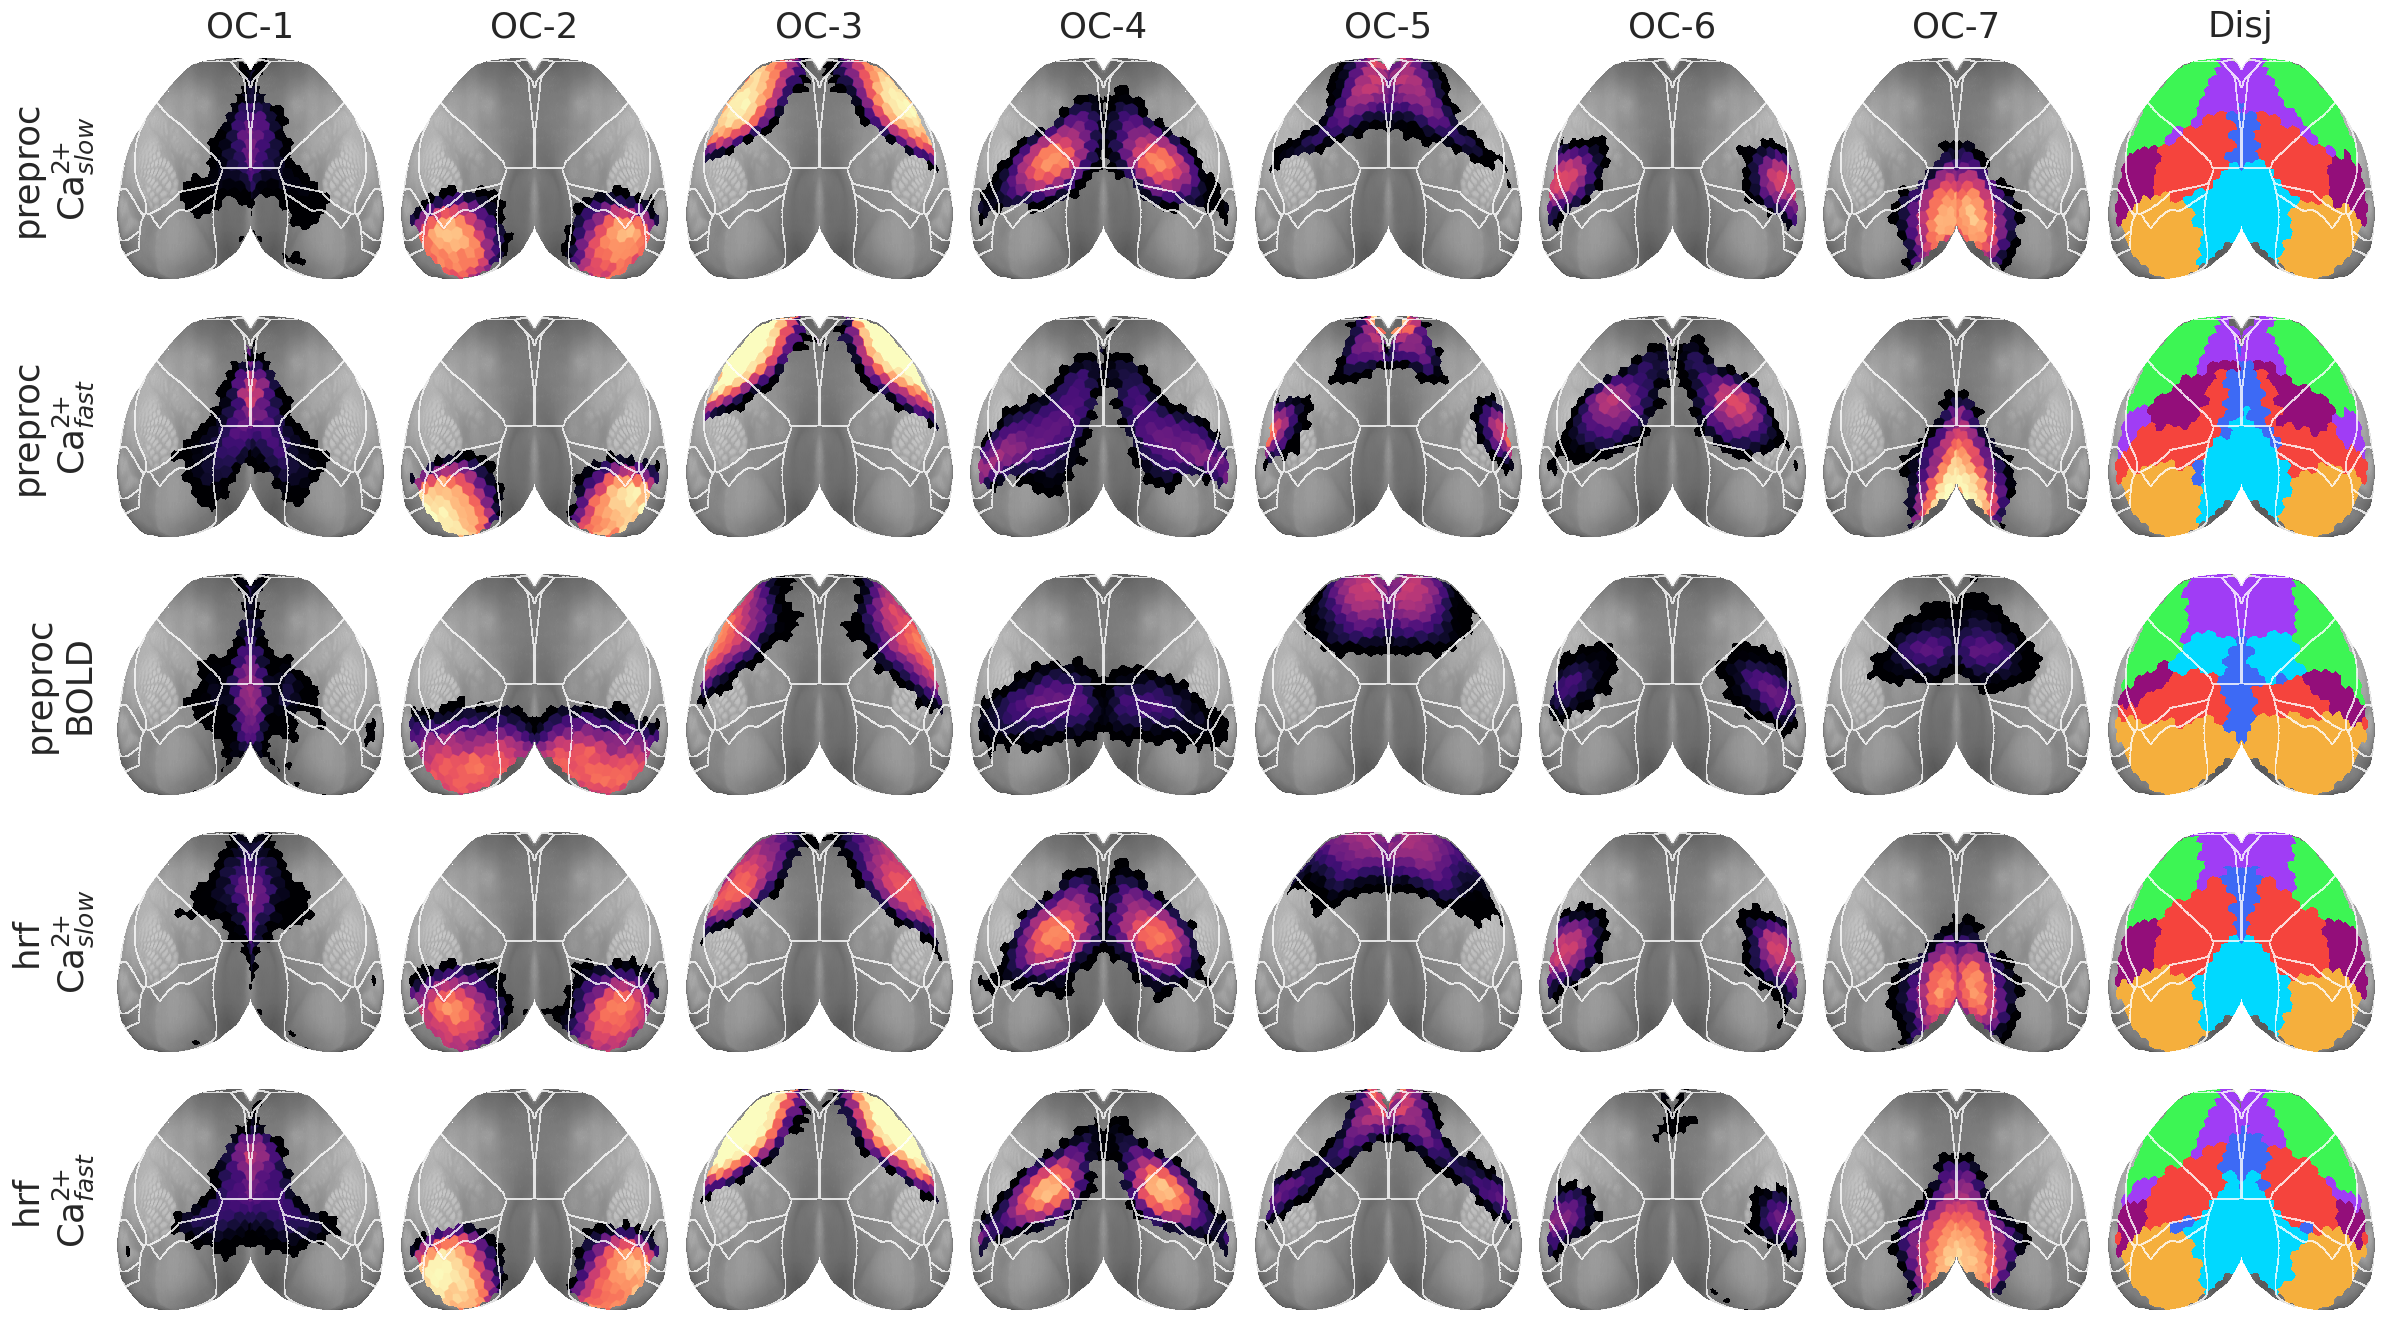

In [5]:
fig, axes = bs.show(pi_avg, **kws_show)

## Entropy

In [10]:
ent = {**get_entropy('preproc'), **get_entropy('hrf')}

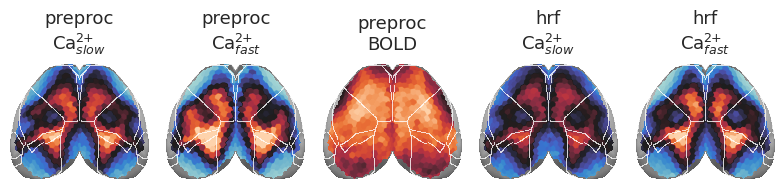

In [22]:
bs.show(
    np.stack(ent.values()),
    titles=ent, figsize=(8, 4),
    vmin=0.0, vmax=0.5,
    cmap='icefire',
);

In [17]:
{k: (np.round(np.nanmin(v), 3), np.round(np.nanmax(v), 3)) for k, v in ent.items()}

{
    'preproc\nCa$^{2\\!\\!+}_{slow}$': (0.027, 0.502),
    'preproc\nCa$^{2\\!\\!+}_{fast}$': (0.017, 0.588),
    'preproc\nBOLD': (0.262, 0.498),
    'hrf\nCa$^{2\\!\\!+}_{slow}$': (0.052, 0.416),
    'hrf\nCa$^{2\\!\\!+}_{fast}$': (0.016, 0.543)
}

In [18]:
for k, v in ent.items():
    good = np.logical_and(
        np.isfinite(ent['preproc\nBOLD']),
        np.isfinite(v),
    )
    r = sp_stats.pearsonr(ent['preproc\nBOLD'][good], v[good])
    print(k, r)

preproc
Ca$^{2\!\!+}_{slow}$
PearsonRResult(statistic=0.6502649478114326, pvalue=3.235481768028636e-66)

preproc
Ca$^{2\!\!+}_{fast}$
PearsonRResult(statistic=0.6254036495293072, pvalue=9.240108827337057e-59)

preproc
BOLD
PearsonRResult(statistic=0.9999999999999999, pvalue=0.0)

hrf
Ca$^{2\!\!+}_{slow}$
PearsonRResult(statistic=0.6497414430716169, pvalue=4.445906646561812e-66)

hrf
Ca$^{2\!\!+}_{fast}$
PearsonRResult(statistic=0.6272723289411543, pvalue=4.4847974710158496e-60)

In [19]:
for k, v in ent.items():
    good = np.logical_and(
        np.isfinite(ent['preproc\nBOLD']),
        np.isfinite(v),
    )
    d = np.linalg.norm(ent['preproc\nBOLD'][good] - v[good])
    print(k, d)

preproc
Ca$^{2\!\!+}_{slow}$ 4.91494510354014

preproc
Ca$^{2\!\!+}_{fast}$ 5.34464985015713

preproc
BOLD 0.0

hrf
Ca$^{2\!\!+}_{slow}$ 4.624506782303682

hrf
Ca$^{2\!\!+}_{fast}$ 5.211111835962305